In [1]:
import line_profiler
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import sys
from tqdm import tqdm
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
from track import Track
from track3D import Track3D
from hit import Hit


In [12]:
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/10h/data_0000.root' ## later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing

hits_tree = 'board_57'
evt_tree = 'event'
# br_list_data = ['n_hits', 'tofpet_id', 'tofpet_channel', 'timestamp']#, 't_coarse', 't_fine', 'timestamp', 'v_coarse', 'v_fine', 'value', 'timestamp_cal_chi2', 'timestamp_cal_dof', 'value_cal_chi2', 'value_cal_dof', 'value_saturation']
br_list_data = ['n_hits', 'tofpet_id', 'tofpet_channel', 'timestamp', 't_coarse', 't_fine', 'timestamp', 'v_coarse', 'v_fine', 'value']
br_list_evt = ['timestamp', 'evt_number', 'flags']
with uproot.open(file_path) as tree:
    hits_dict = tree[hits_tree].arrays(br_list_data, library="np")
    evts_dict = tree[evt_tree].arrays(br_list_evt, library="np")
    
# df_hits = pd.DataFrame.from_dict(hits_dict).query('n_hits > 3')
df_hits = pd.DataFrame.from_dict(hits_dict)
df_evts = pd.DataFrame.from_dict(evts_dict)
df_hits['timestamp_event'] = df_evts['timestamp']
df_hits.query('n_hits > 6', inplace=True)


In [13]:
## This function provide the parameters x0 (or y0 depending on which hits we provide) and tx the angle of the trac
def create_tracks(df, plot = False):
    tracks = []
    nb_events = len(df['n_hits'])
    steps = 9
    buff_start = None
    buff_evt_idx = None
    dts = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0]):
        channels = row['tofpet_channel']
        tofpet_id = row['tofpet_id']
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D(hits)
            tracks.append(track)
            # track_x = Track(hitsX)
            # track_y = Track(hitsY)
            # tracks.append(track_x)
            # tracks.append(track_y)

            ## check if track has a "good" chi2 value
            if track.is_good_2D_fit():
                # worth making a precise track
                track.precise_track()
                
                ## compute the time of the track
                dt = track.get_time_interval()
                if dt is not None:
                    dts.append(dt)


    return tracks, dts
    

In [14]:
tracks, dts = create_tracks(df_hits)
chi_squares = [track.reduced_chi2() for track in tracks]

100%|██████████| 46564/46564 [31:32<00:00, 24.60it/s]  


Text(0, 0.5, 'counts')

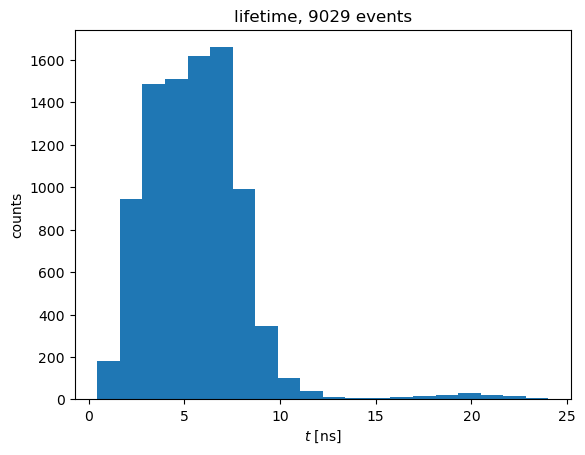

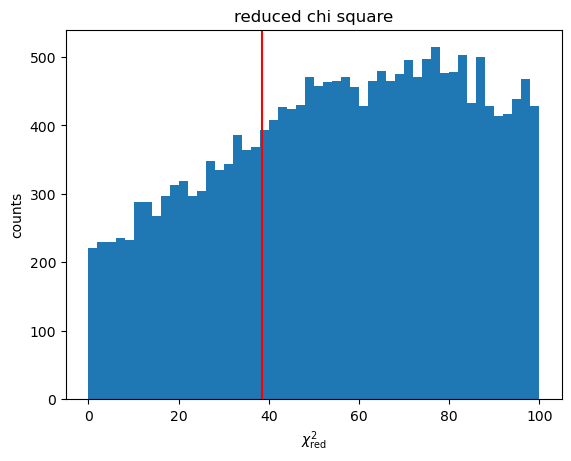

In [17]:
plt.figure()
plt.title('lifetime, {} events'.format(len(dts)))
plt.hist(np.array(dts)*6.25, bins = 20)
# plt.yscale('log')
plt.xlabel('$t$ [ns]')
plt.ylabel('counts')

plt.figure()
plt.title('reduced chi square')
plt.hist(chi_squares, bins = 50, range = [0, 100])
plt.axvline(x = 10 * 3.841, ymin = 0.0, ymax = 1.0, color = 'r')
plt.xlabel('$\chi^2_{\mathrm{red}}$')
plt.ylabel('counts')